In the following chunk I have defined a function which reads the chosen video from the memory and processes it throuth the chosen technique (the one implemented using Watershed, or the other one implemented using HSV colour space filtering and edge detection), and at the same time stores each transformed frame.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from watershed_segmentation import watershed_segmentation, watershed_segmentation_co
from custom_segmentation import hsv_and_edge_segmentation

# ! OLD METHOD (multiprocessing)
# !  -------from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor as Pool


def fromiter_map_function(iterable: list, function: callable) -> np.ndarray:
    """Start a multi process pool and assign 40 elements for each available process.
    Each element will be processed through the given function, and all the results
    will be incapsulated into a numpy array.

    Args:
        iterable (list): input to process in parallel through the given function.
        function (callable): function used to process the input collection.

    Returns:
        np.ndarray: results.
    """
    # ! ORIGINAL MULTIPROC METHOD: required output transformation to list/array.
    # with Pool() as pool:
    #     return np.array(
    #         pool.map(
    #             function,
    #             iterable,
    #             chunksize=2,
    #         )
    #     )
    with Pool() as pool:
        return pool.map(
                function,
                iterable,
            )



def video_segmentation(
    video_path: str, chosen_technique: int, object_index: int
) -> None:
    """Perform the image segmentation using the watershed based technique or
    the hsv+edge detection technique on the chosen video, and save the
    transformed version of it as a new video.

    Args:
        video_path (str): path of original video, used to determine the new name/path.
        chosen_technique (int): index of the chosen segmentation technique.
        object_index (int): index of the chosen video/object.

    Raises:
        Exception: Exception thrown in case of unsuccesful opening of the video.
    """

    # Start the video capturer, to extract the frames from the original frame.
    vidcap = cv.VideoCapture(video_path)
    success, frame = vidcap.read()

    # If success is false, the VideoCapture didn't succede, hence terminate
    # unsuccessfully.
    if success:
        # If success = True, retrieve the shape of the original frame.
        (h, w) = frame.shape[:2]
    else:
        raise Exception("Video aperture failed!")

    # Extract the number of frames to use a for loop instead of a while.
    num_of_frames = int(vidcap.get(cv.CAP_PROP_FRAME_COUNT))
    # Extract the number of frames to create an output video with the
    # same framerate.
    fps = vidcap.get(cv.CAP_PROP_FPS)

    # Create output path.
    output_path = video_path.replace(".mp4", "_mask.mp4")
    # Choose the same video format of the input videos.
    fourcc = cv.VideoWriter_fourcc("m", "p", "4", "v")

    # Start an OpenCV videowriter to write the frames on the new video.
    out = cv.VideoWriter(output_path, fourcc, fps, (w, h))

    if chosen_technique == 0:
        for _ in range(num_of_frames):
            if success:
                transformed_frame = watershed_segmentation(frame, object_index)
                out.write(transformed_frame)
                success, frame = vidcap.read()
            else:
                break
    else:
        for _ in range(num_of_frames):
            if success:
                transformed_frame = hsv_and_edge_segmentation(frame)
                out.write(transformed_frame)
                success, frame = vidcap.read()
            else:
                break
    # Releas the video reader.
    vidcap.release()
    # Releas the video writer.
    out.release()

    # Closes all the windows currently opened.
    cv.destroyAllWindows()


def parallel_video_segmentation(
    video_path: str, chosen_technique: int, object_index: int
) -> None:
    """Perform the image segmentation using the watershed based technique or
    the hsv+edge detection technique on the chosen video, and save the
    transformed version of it as a new video.

    Args:
        video_path (str): path of original video, used to determine the new name/path.
        chosen_technique (int): index of the chosen segmentation technique.
        object_index (int): index of the chosen video/object.

    Raises:
        Exception: Exception thrown in case of unsuccesful opening of the video.
    """

    # Start the video capturer, to extract the frames from the original frame.
    vidcap = cv.VideoCapture(video_path)
    success, frame = vidcap.read()

    # If success is false, the VideoCapture didn't succede, hence terminate
    # unsuccessfully.
    if success:
        # If success = True, retrieve the shape of the original frame.
        (h, w) = frame.shape[:2]
    else:
        raise Exception("Video aperture failed!")

    # Extract the number of frames to use a for loop instead of a while.
    num_of_frames = int(vidcap.get(cv.CAP_PROP_FRAME_COUNT))
    # Extract the number of frames to create an output video with the
    # same framerate.
    fps = vidcap.get(cv.CAP_PROP_FPS)

    # Create output path.
    output_path = video_path.replace(".mp4", "_mask.mp4")
    # Choose the same video format of the input videos.
    fourcc = cv.VideoWriter_fourcc("m", "p", "4", "v")

    loaded_frames = []

    for _ in range(num_of_frames):
        if success:
            loaded_frames.append(frame)
            success, frame = vidcap.read()
        else:
            break
    # Releas the video reader.
    vidcap.release()

    # Start an OpenCV videowriter to write the frames on the new video.
    out = cv.VideoWriter(output_path, fourcc, fps, (w, h))

    # ! FIXED TYPO: replaced "chosen_video" with "object_index".
    callable_technique = watershed_segmentation_co(object_indx= object_index) if chosen_technique == 0 else hsv_and_edge_segmentation
    transformed_frames = fromiter_map_function(iterable=loaded_frames, function=callable_technique)
    
    [out.write(transformed_frame) for transformed_frame in transformed_frames]

    # Releas the video writer.
    out.release()

    # Closes all the windows currently opened.
    cv.destroyAllWindows()


#### INPUT SELECTION: START
chosen_technique = int(
    input("Choose the segmentation method [0 Watershed, 1 Custom-Hsv-Edge]:")
)
while chosen_technique not in [0, 1]:
    chosen_technique = int(
        input("Choose the segmentation method [0 Watershed, 1 -Hsv-Edge]:")
    )

chosen_video = int(
    input("Choose which video to process [1 Toucan, 2 Dinosaur, 3 Cracker, 4 Statue]:")
)
while chosen_video not in [1, 2, 3, 4]:
    chosen_video = int(
        input(
            "Choose which video to process [1 Toucan, 2 Dinosaur, 3 Cracker, 4 Statue]:"
        )
    )
#### INPUT SELECTION: END

# Start the processing.
parallel_video_segmentation(
    video_path=f"../data/obj0{chosen_video}.mp4",
    chosen_technique=chosen_technique,
    object_index=chosen_video,
)

Follows the section dedicated to the comparison of the results of the developed techinques against the ground truth, with the use of **confusion matrices** and even **accuracy**, **precision** and **recall** scores. First I define a function which will retrieve the test data and use it to plot a confusion matrix for the chosen video (along with a table that will include accuracy, precision and recall), and later I will invoke such function on each of the available test folders/objects.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import glob
import cv2 as cv
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score
from custom_segmentation import hsv_and_edge_segmentation
from watershed_segmentation import watershed_segmentation
import pandas as pd


def show_performance(chosen_video : int) -> pd.DataFrame:
    """This function retrieves the test data, splits it into
    data to transform and ground trouth data, transforms the
    data through the segmentation techniques, and compares
    the results using confusion matrices, accuracy, precision,
    and recall.

    Args:
        chosen_video (int): chosen video.

    Returns:
        pd.DataFrame: panda dataframe containing the accuracy,
        precision and recall data.
    """
    test_dataset_images = [
        cv.imread(path)
        for path in glob.glob(f"../assignment1_test_dataset/obj0{chosen_video}/*.png")
    ]

    # Split test data into non-transformed and transformed (i.e., ground truth) frames.
    original_test_frames1 = deepcopy(test_dataset_images[0::2])
    original_test_frames2 = deepcopy(test_dataset_images[0::2])
    ground_truth_images = test_dataset_images[1::2]

    # Transform the non-transformed frames using the two techniques.
    transformed_test_frames_hsv_seg = [
        hsv_and_edge_segmentation(orig_image) for orig_image in original_test_frames1
    ]
    transformed_test_frames_wt_seg = [
        watershed_segmentation(orig_image, chosen_video)
        for orig_image in original_test_frames2
    ]

    # Convert ground truth, watershed and hsv segmented frames into the gray colour.
    hsv_col_conv = [
        cv.cvtColor(frame, cv.COLOR_BGR2GRAY) for frame in transformed_test_frames_hsv_seg
    ]
    wt_col_conv = [
        cv.cvtColor(frame, cv.COLOR_BGR2GRAY) for frame in transformed_test_frames_wt_seg
    ]
    gt_col_conv = [cv.cvtColor(frame, cv.COLOR_BGR2GRAY) for frame in ground_truth_images]

    # Correction of ground truth images: as we need to consider only
    # negative/positive classes for the confusion matrix comparison, I
    # need to remove any intermediate value between 0 and 255 (not included),
    # hence any value bigger than zero will be set to 255 (problem found with statue).
    for frame in gt_col_conv:
        frame[frame > 0] = 255

    # Flatten the arrays to check if they match pixel by pixel in the confusion matrix
    ground_truth = np.array(gt_col_conv).flatten().flatten()
    hsv_seg_prediction = np.array(hsv_col_conv).flatten().flatten()
    wt_seg_prediction = np.array(wt_col_conv).flatten().flatten()

    # del ground_truth, hsv_seg_prediction, wt_seg_prediction

    # Create the matplotlib figure and axes needed to plot the confusion matrices.
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 10), sharey="row")

    # Compute the confusion matrices.
    confusion_matrix_hsv = metrics.confusion_matrix(ground_truth, hsv_seg_prediction)
    confusion_matrix_wt = metrics.confusion_matrix(ground_truth, wt_seg_prediction)

    # Extract their display, to plot them.
    hsv_cf_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix_hsv, display_labels=["Negative", "Positive"]
    )
    wt_cf_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix_wt, display_labels=["Negative", "Positive"]
    )

    # Rotate the labels.
    hsv_cf_display.plot(ax=axes[0], xticks_rotation=45)
    wt_cf_display.plot(ax=axes[1], xticks_rotation=45)

    # Set the title for each displayed confusion matrix.
    hsv_cf_display.ax_.set_title("Custom HSV segmentation")
    wt_cf_display.ax_.set_title("Watershed segmentation")

    # Remove the colourbars.
    hsv_cf_display.im_.colorbar.remove()
    wt_cf_display.im_.colorbar.remove()

    # Remove the x labels on the individual cfs.
    hsv_cf_display.ax_.set_xlabel("")
    wt_cf_display.ax_.set_xlabel("")

    # Remove the y labels on the second plot, to use the ones
    # of the first as labels for both.
    wt_cf_display.ax_.set_ylabel("")

    # Define the size of the label "Predicted label".
    figure.text(0.4, 0.1, "Predicted label", ha="left")
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    # Set a colourbar for both the cfs and plot them.
    figure.colorbar(wt_cf_display.im_, ax=axes)
    plt.show()

    # Compute accuracy, precision and recall for both the techniques, and show the
    # results in the table.
    # Precision:  Measure of ability to avoid FP  =   TP / TP+FP.
    # Recall:     Measure of ability to avoid FN  =   TP / TP+FN.
    # Accuracy:   Overall correctness of the predictions. = (TP + TN) / (TP + TN + FP + FN)
    wt_acc_score = accuracy_score(ground_truth, wt_seg_prediction)
    hsv_acc_score = accuracy_score(ground_truth, hsv_seg_prediction)

    wt_prec_score = precision_score(ground_truth, wt_seg_prediction, pos_label=255)
    hsv_prec_score = precision_score(ground_truth, hsv_seg_prediction, pos_label=255)

    wt_rec_score = recall_score(ground_truth, wt_seg_prediction, pos_label=255)
    hsv_rec_score = recall_score(ground_truth, hsv_seg_prediction, pos_label=255)

    
    dict = {'Type of score':["Accuracy", "Precision", "Recall"],
            'Watershed scores': [round(wt_acc_score, 4), round(wt_prec_score, 4), round(wt_rec_score, 4)],
            'HSV scores':[round(hsv_acc_score, 4), round(hsv_prec_score, 4), round(hsv_rec_score, 4)]}
    
    df = pd.DataFrame(dict)
    return df 

Here we see how the two techniques behave on the first folder (i.e., test frames extracted from the Toucan video).

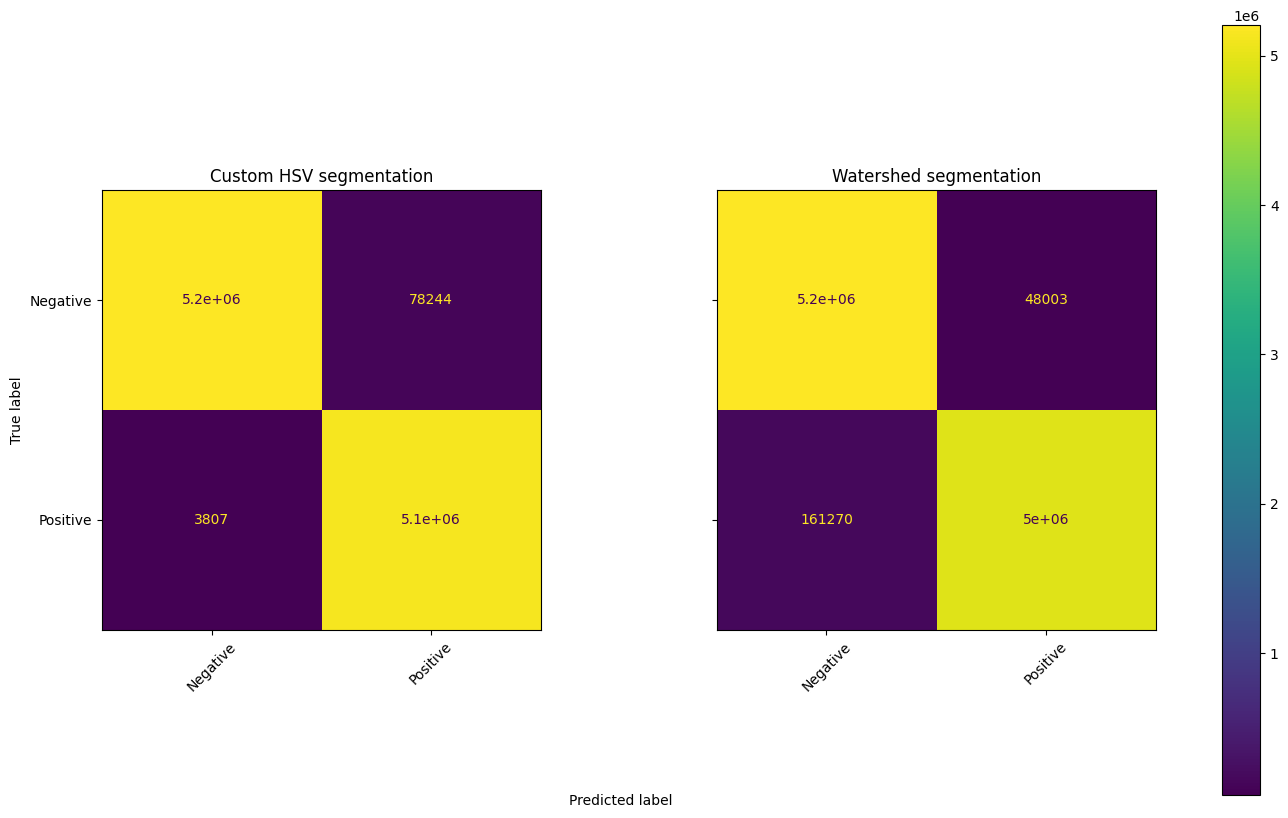

,Type of score,Watershed scores,HSV scores
0,Accuracy,0.9798,0.9921
1,Precision,0.9904,0.9849
2,Recall,0.9685,0.9993


In [3]:
pd1 = show_performance(chosen_video=1)
pd1

Now the same for the Dinosaur video.

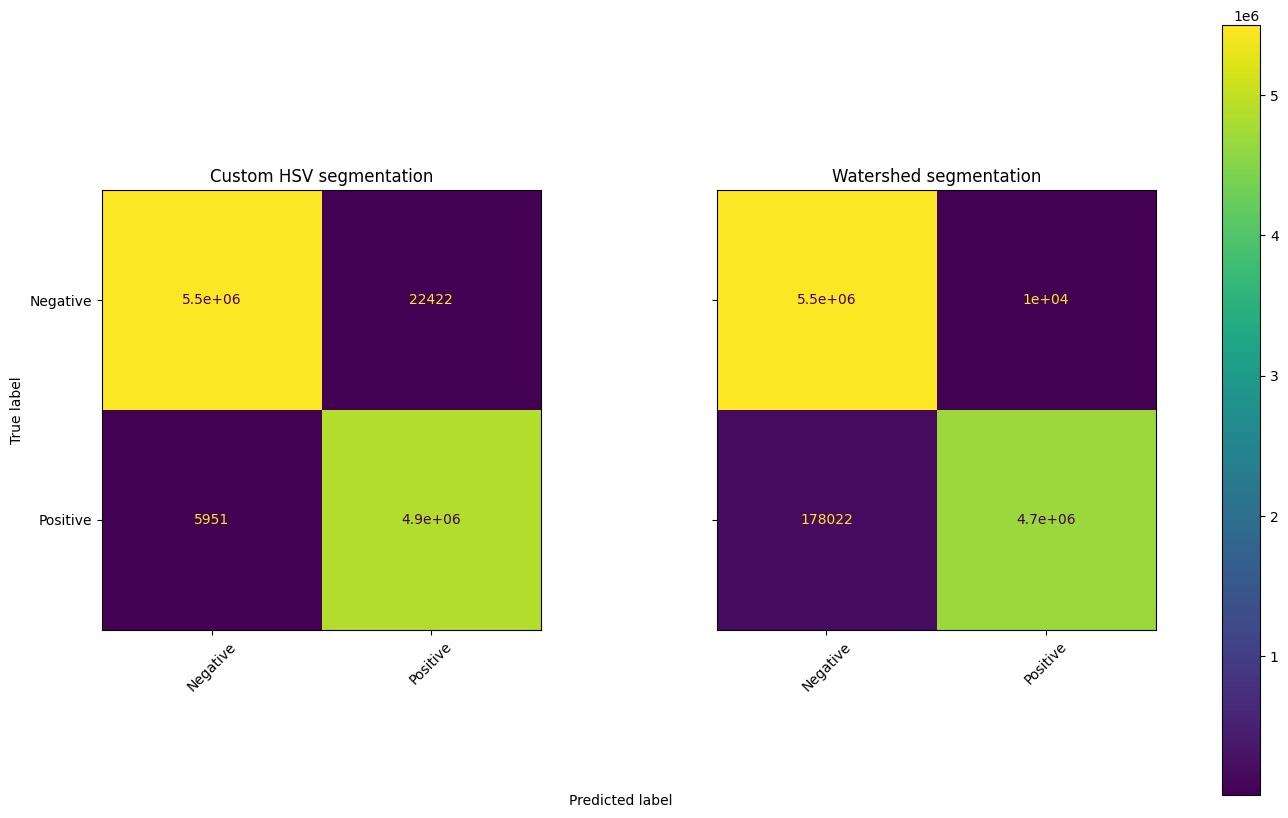

,Type of score,Watershed scores,HSV scores
0,Accuracy,0.9818,0.9973
1,Precision,0.9978,0.9954
2,Recall,0.9634,0.9988


In [4]:
pd2 = show_performance(chosen_video=2)
pd2

And again for the statue video (No folder is available for the cracker).

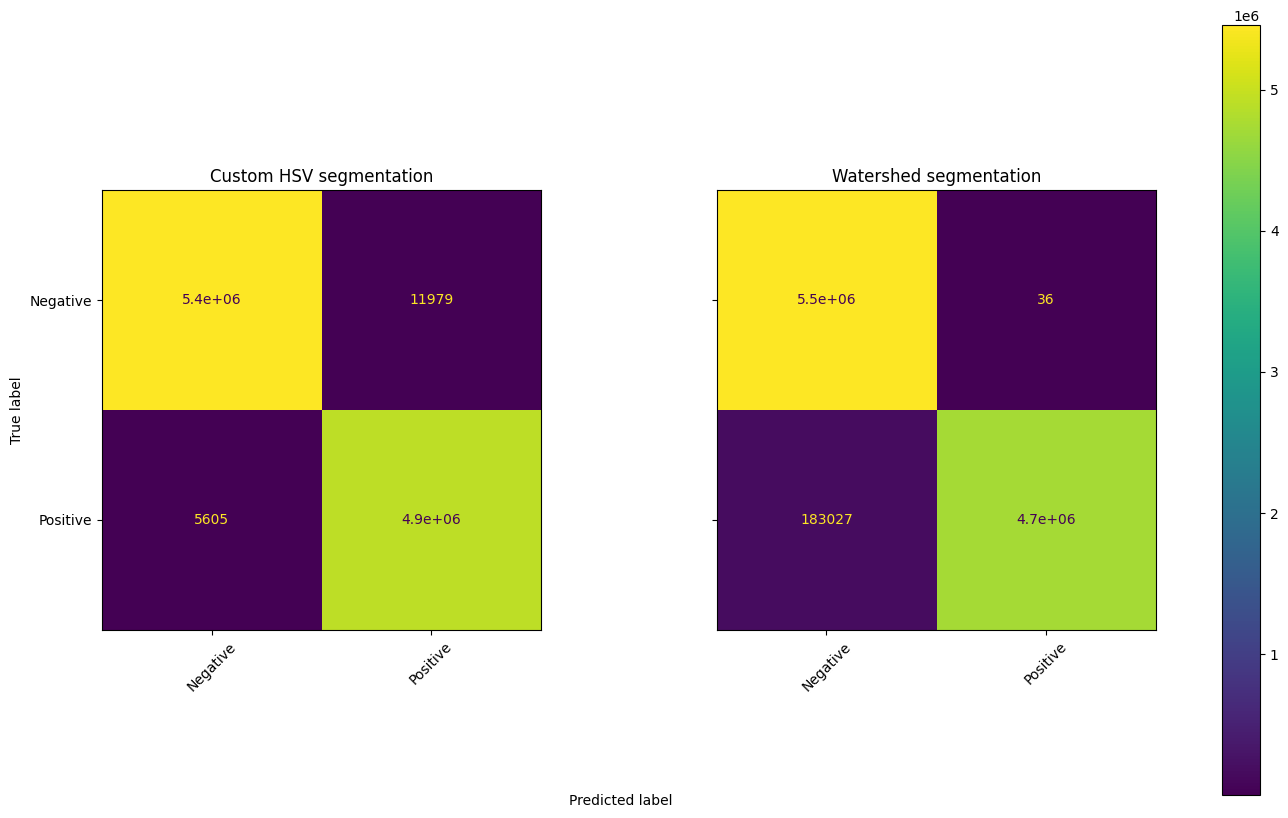

,Type of score,Watershed scores,HSV scores
0,Accuracy,0.9823,0.9983
1,Precision,1.0000,0.9976
2,Recall,0.9627,0.9989


In [5]:
pd4 = show_performance(chosen_video=4)
pd4

Eventually, let's give a look to the avarage accuracy, precision and recall achieved by the two techniques:

In [6]:
avg_wt_accuracy = (pd1["Watershed scores"][0] + pd2["Watershed scores"][0] + pd4["Watershed scores"][0]) / 3.
avg_wt_precision = (pd1["Watershed scores"][1] + pd2["Watershed scores"][1] + pd4["Watershed scores"][1]) / 3.
avg_wt_recall = (pd1["Watershed scores"][2] + pd2["Watershed scores"][2] + pd4["Watershed scores"][2]) / 3.

avg_hsv_accuracy = (pd1["HSV scores"][0] + pd2["HSV scores"][0] + pd4["HSV scores"][0]) / 3.
avg_hsv_precision = (pd1["HSV scores"][1] + pd2["HSV scores"][1] + pd4["HSV scores"][1]) / 3.
avg_hsv_recall = (pd1["HSV scores"][2] + pd2["HSV scores"][2] + pd4["HSV scores"][2]) / 3.

dict = {'Type of score':["Accuracy", "Precision", "Recall"],
            'Watershed scores': [round(avg_wt_accuracy, 4), round(avg_wt_precision, 4), round(avg_wt_recall, 4)],
            'HSV scores':[round(avg_hsv_accuracy, 4), round(avg_hsv_precision, 4), round(avg_hsv_recall, 4)]}
total_df = pd.DataFrame(dict)
total_df

,Type of score,Watershed scores,HSV scores
0,Accuracy,0.9813,0.9959
1,Precision,0.9961,0.9926
2,Recall,0.9649,0.9990


As we can see, both the techniques achieve important values, in fact they are all near to 100%, and the custom solution seems to outperform by a little the watershed one in terms of accuracy and recall, but loses a bit in terms of precision, meaning that the HSV technique on average tends to include in the white part a bit more of the background, which depends from the bigger number of morphological operations included in the HSV technique, and also due to the higher number of iterations for each of such operations. I chose to make use of those operations to ensure that the technique, at the expense of a little loss in accuracy with some objects, would have kept bigger parts of complex objects such as Crackers (which unfortunately is untested) and the Toucan, which both include different colours and are of larger sizes, meaning that they include more variations in terms of illumination. 